
# Using 6000 training samples - it fits memory!


In [1]:
import os, cv2, random
import numpy as np
import pandas as pd

In [2]:
import theano


Using gpu device 0: GRID K520 (CNMeM is enabled)


In [4]:
from keras import backend as K
K.image_dim_ordering()

'tf'

In [3]:
#needs at least 1.0.6 to run pre-trained models
import keras
keras.__version__

Using Theano backend.


'1.1.0'

In [5]:
# 'th' setting is needed to use pre-trained model
K.set_image_dim_ordering('th')
K.image_dim_ordering()

'th'

In [6]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential, Model
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation,GlobalAveragePooling2D,ZeroPadding2D
from keras.optimizers import RMSprop, SGD
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

This code below to process image is from Jeff Delaney, who publicly shared his algorithm on Kaggle Kernel.

In [7]:
TRAIN_DIR = 'data/train/'
TEST_DIR = 'data/test/'

#using the VGG16 default image size
ROWS = 112
COLS = 112
CHANNELS = 3

#train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]


# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset, try using as many images as memory allows
train_images = train_dogs[:3] + train_cats[:3]
val_images=train_dogs[-5:]+train_cats[-5:]

random.shuffle(train_images)
random.shuffle(val_images)
test_images =  test_images

def read_image(file_path):
    
    img=cv2.resize(cv2.imread(file_path), (ROWS, COLS), interpolation=cv2.INTER_CUBIC).astype(np.float32)
    img=img.transpose((2,0,1)) #use this if you want the image to be (channel, row, cols)
    return img

def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS ))

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image
        #if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data



In [8]:
#note: the names of the test files don't come sorted numerically! split the names and map the number to integer
index=[]
for i in os.listdir(TEST_DIR):

    num,fil=i.split('.')
    index.append(num)
ID = list(map(int, index))

In [9]:
train = prep_data(train_images)
test = prep_data(test_images)
val=prep_data(val_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Train shape: (6, 3, 112, 112)
Test shape: (12500, 3, 112, 112)


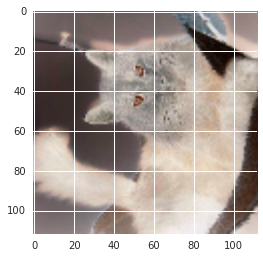

In [10]:
#shows a sample picture 
plt.imshow(train[3].T)

In [11]:
img_width, img_height = 112, 112

train_data_dir = 'train2'
validation_data_dir = 'validation'

nb_train_samples = 6000
nb_validation_samples = 2000
nb_epoch = 10

# Preparing the VGG pre-trained model 
(source:Francoise Chollet https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

In [12]:
import h5py

In [13]:
def VGG_16():
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(3,img_width, img_height)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    

    weights_path='vgg16_weights_original.h5'
    #courtesy of xyz on kaggle, this adjust the index for the weights to be loaded into the model, because
    #input image size is not 224
    assert os.path.exists(weights_path), 'Model weights not found (see "weights_path" variable in script).'
    f = h5py.File(weights_path)
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers):break
    # we don't look at the last (fully-connected) layers in the savefile
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        model.layers[k].set_weights(weights) #sets the selected weight from pre-trained weight
    f.close()
    print('Model loaded.')

 
    return model

In [14]:
model2=VGG_16()

Model loaded.


In [15]:
from keras.preprocessing.image import ImageDataGenerator

In [16]:
datagen = ImageDataGenerator(rescale=1./255)

In [17]:
generator = datagen.flow_from_directory(
            train_data_dir,
            classes=['cats','dogs'], #order - cats first
            target_size=(img_width, img_height),
            batch_size=32,
            class_mode=None,
            shuffle=False)

Found 6000 images belonging to 2 classes.


In [ ]:
bottleneck_features_train = model2.predict_generator(generator, nb_train_samples)
    
np.save(open('bottleneck_features_train.npy', 'w'), bottleneck_features_train)#for 6000 training samples

In [18]:
generator = datagen.flow_from_directory(
            validation_data_dir,
            classes=['cats','dogs'],
            target_size=(img_width, img_height),
            batch_size=32,
            class_mode=None,
            shuffle=False)

Found 2000 images belonging to 2 classes.


In [ ]:
bottleneck_features_validation = model2.predict_generator(generator, nb_validation_samples)
np.save(open('bottleneck_features_validation.npy', 'w'), bottleneck_features_validation)

In [19]:
train_data = np.load(open('bottleneck_features_train.npy'))
train_labels = np.array([0] * (nb_train_samples / 2) + [1] * (nb_train_samples / 2))
print(train_data.shape)

(6000, 512, 3, 3)


In [20]:
validation_data = np.load(open('bottleneck_features_validation.npy'))
validation_labels = np.array([0] * (nb_validation_samples / 2) + [1] * (nb_validation_samples / 2))
print(validation_data.shape)

(2000, 512, 3, 3)


In [21]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


In [22]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
from keras.callbacks import History 
history = History()
early_stopping=EarlyStopping(monitor='val_loss', patience=3)

In [24]:
model.fit(train_data, train_labels,
              nb_epoch=nb_epoch, batch_size=32,verbose=1,
              validation_data=(validation_data, validation_labels))

#run 10 epochs

Train on 6000 samples, validate on 2000 samples
Epoch 1/10
6000/6000 [==============================] - 0s - loss: 0.4645 - acc: 0.7998 - val_loss: 0.3640 - val_acc: 0.8400
Epoch 2/10
6000/6000 [==============================] - 0s - loss: 0.3330 - acc: 0.8548 - val_loss: 0.3262 - val_acc: 0.8670
Epoch 3/10
6000/6000 [==============================] - 0s - loss: 0.2952 - acc: 0.8695 - val_loss: 0.3021 - val_acc: 0.8750
Epoch 4/10
6000/6000 [==============================] - 0s - loss: 0.2818 - acc: 0.8807 - val_loss: 0.3019 - val_acc: 0.8750
Epoch 5/10
6000/6000 [==============================] - 0s - loss: 0.2500 - acc: 0.8943 - val_loss: 0.3208 - val_acc: 0.8750
Epoch 6/10
6000/6000 [==============================] - 0s - loss: 0.2339 - acc: 0.9045 - val_loss: 0.3773 - val_acc: 0.8510
Epoch 7/10
6000/6000 [==============================] - 0s - loss: 0.2281 - acc: 0.9098 - val_loss: 0.3448 - val_acc: 0.8635
Epoch 8/10
6000/6000 [==============================] - 0s - loss: 0.2073 - a

In [25]:
model.save_weights('bottleneck_fc_model(dense128).h5')


In [26]:
top_model = Sequential()
top_model.add(Flatten(input_shape=model2.output_shape[1:]))
top_model.add(Dense(128, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

In [27]:
top_model.load_weights('bottleneck_fc_model(dense128).h5')

In [28]:
model2.add(top_model)

In [29]:
# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model2.layers[:25]:
    layer.trainable = False

In [30]:
model2.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [31]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
#train_datagen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(3,1,1)

In [32]:
test_datagen = ImageDataGenerator(rescale=1./255)
#test_datagen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(3,1,1)

In [33]:
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        classes=['cats','dogs'],
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='binary')


Found 6000 images belonging to 2 classes.


In [34]:
validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        classes=['cats','dogs'],
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.


In [35]:
# fine-tune the model
mf=model2.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,verbose=1,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples)


Epoch 1/10
6000/6000 [==============================] - 114s - loss: 0.2839 - acc: 0.8890 - val_loss: 0.3047 - val_acc: 0.8805
Epoch 2/10
6000/6000 [==============================] - 114s - loss: 0.2335 - acc: 0.9070 - val_loss: 0.2734 - val_acc: 0.8960
Epoch 3/10
6000/6000 [==============================] - 114s - loss: 0.2164 - acc: 0.9103 - val_loss: 0.2550 - val_acc: 0.8980
Epoch 4/10
6000/6000 [==============================] - 114s - loss: 0.2052 - acc: 0.9138 - val_loss: 0.2662 - val_acc: 0.8990
Epoch 5/10
6000/6000 [==============================] - 114s - loss: 0.1899 - acc: 0.9245 - val_loss: 0.2407 - val_acc: 0.9075
Epoch 6/10
6000/6000 [==============================] - 114s - loss: 0.1678 - acc: 0.9315 - val_loss: 0.2575 - val_acc: 0.9020
Epoch 7/10
6000/6000 [==============================] - 114s - loss: 0.1609 - acc: 0.9347 - val_loss: 0.2362 - val_acc: 0.9115
Epoch 8/10
6000/6000 [==============================] - 114s - loss: 0.1511 - acc: 0.9375 - val_loss: 0.2509 - 

In [36]:
#normalize the test set by dividing 255 to keep it consistent
test /= 255

In [37]:
predictions = model2.predict(test, verbose=0)


In [38]:
submission=pd.read_csv('sample_submission.csv')
submission.head()

id  label
0   1    0.5
1   2    0.5
2   3    0.5
3   4    0.5
4   5    0.5

In [40]:
submission['label']=predictions
submission['id']=ID
submission.sort('id', inplace=True)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [41]:
submission.head()

id     label
9536    1  0.989012
4155    2  1.000000
6191    3  1.000000
2618    4  1.000000
10062   5  0.000031

In [44]:
submission.to_csv('TL_prediction.csv', index=False)


## Look at sample prediction

I am 100.00% sure this is a Cat


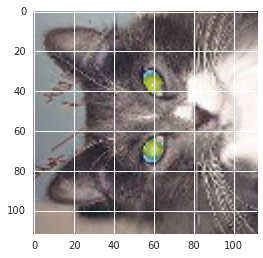

I am 100.00% sure this is a Dog


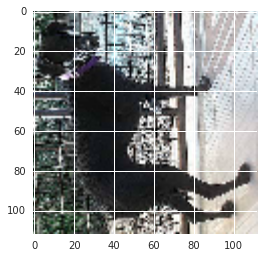

I am 86.75% sure this is a Dog


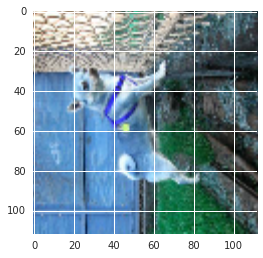

I am 68.47% sure this is a Cat


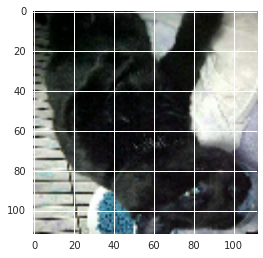

I am 63.38% sure this is a Dog


I am 99.88% sure this is a Dog


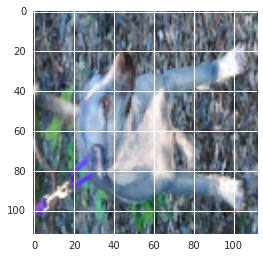

I am 100.00% sure this is a Dog


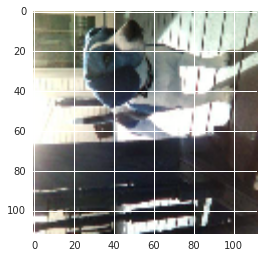

I am 100.00% sure this is a Cat


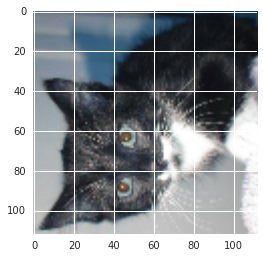

I am 54.08% sure this is a Dog


I am 100.00% sure this is a Dog


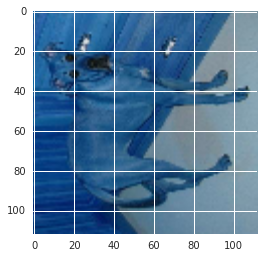

I am 98.85% sure this is a Dog


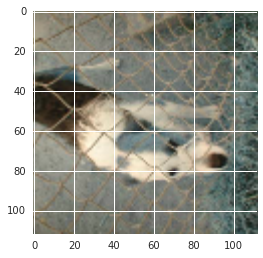

I am 80.63% sure this is a Cat


I am 73.28% sure this is a Dog


I am 100.00% sure this is a Dog


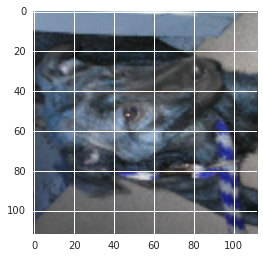

I am 100.00% sure this is a Cat


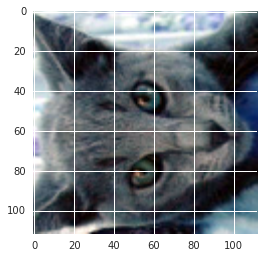

I am 72.43% sure this is a Dog


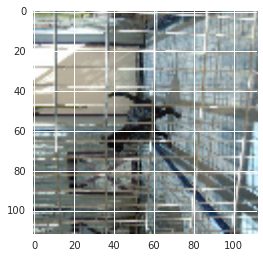

I am 76.72% sure this is a Cat


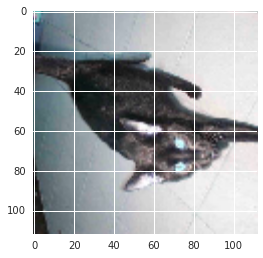

I am 91.37% sure this is a Dog


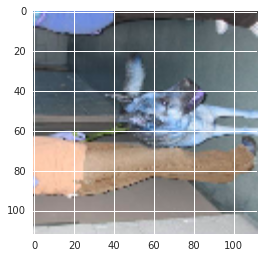

I am 100.00% sure this is a Dog


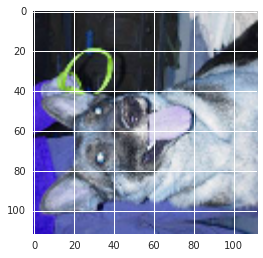

I am 99.87% sure this is a Cat


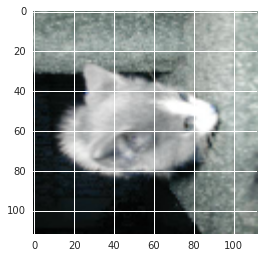

I am 98.95% sure this is a Cat


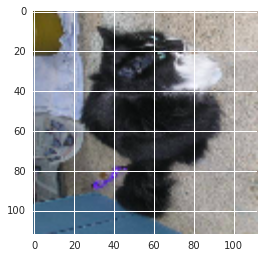

I am 100.00% sure this is a Dog


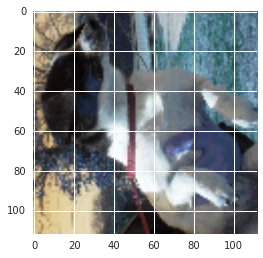

I am 99.77% sure this is a Cat


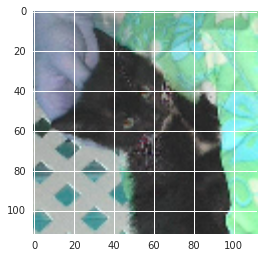

I am 96.07% sure this is a Cat


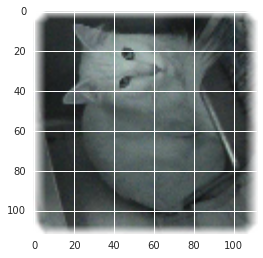

I am 99.76% sure this is a Cat


I am 97.71% sure this is a Dog


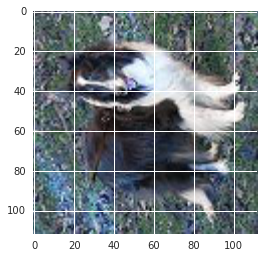

I am 100.00% sure this is a Dog


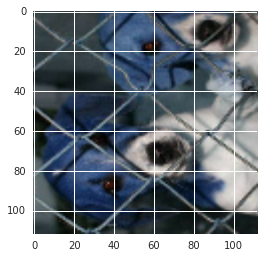

I am 100.00% sure this is a Dog


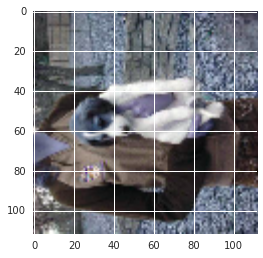

I am 100.00% sure this is a Dog


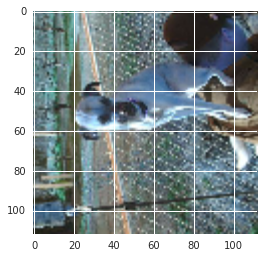

I am 99.98% sure this is a Dog


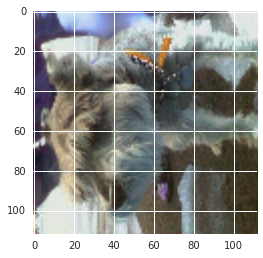

I am 100.00% sure this is a Cat


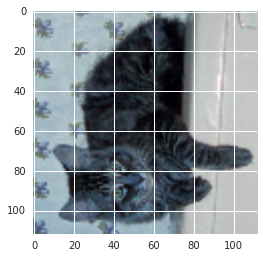

I am 99.98% sure this is a Cat


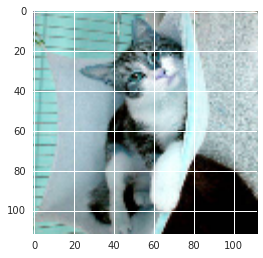

I am 99.98% sure this is a Cat


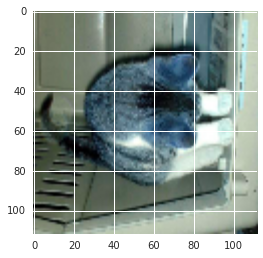

I am 100.00% sure this is a Dog


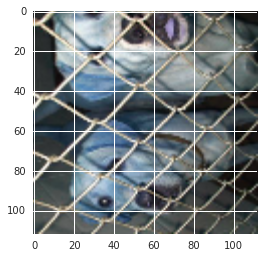

I am 100.00% sure this is a Cat


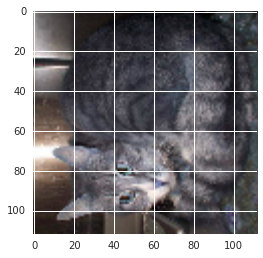

I am 99.86% sure this is a Dog


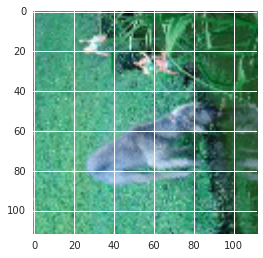

I am 99.98% sure this is a Cat


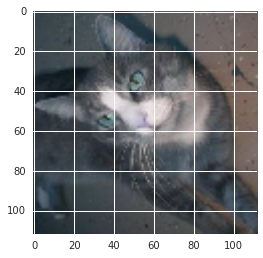

I am 100.00% sure this is a Dog


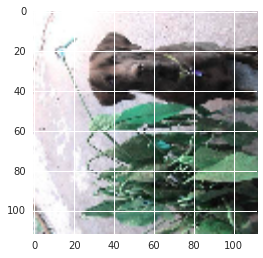

I am 99.90% sure this is a Dog


I am 51.79% sure this is a Dog


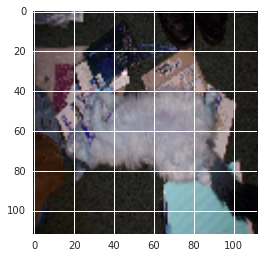

I am 100.00% sure this is a Dog


I am 100.00% sure this is a Cat


I am 99.89% sure this is a Cat


I am 100.00% sure this is a Dog


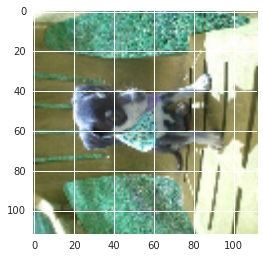

I am 84.66% sure this is a Dog


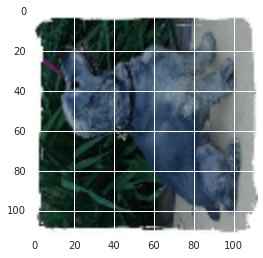

I am 100.00% sure this is a Dog


I am 100.00% sure this is a Cat


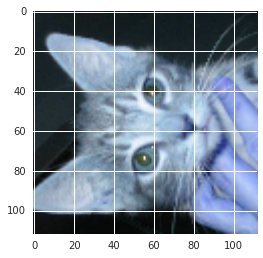

I am 63.59% sure this is a Dog


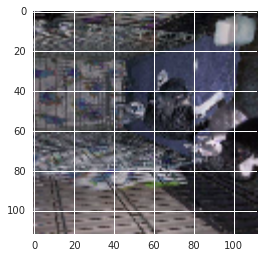

I am 86.08% sure this is a Dog


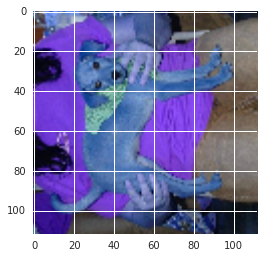

I am 98.56% sure this is a Dog


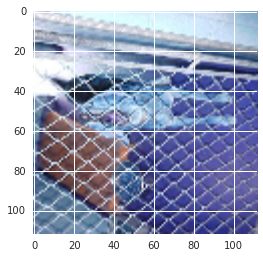

In [43]:
for i in range(0,50):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test[i].T)
    plt.show()